# Intro

### 1. What this dataset is:

This dataset contains scRNA-seq gene expression measurements of bone marrow mononuclear cells (BMMCs) from two patients with acute myeloid leukemia (AML). Measurements were taken before and after the patients underwent stem cell transplants as part of their treatment regimens. The dataset also includes measurements from two healthy control patients.

### 2. Where the data comes from:

This data was collected as part of `Massively parallel digital transcriptional profiling of single cells` (Zheng et al., 2017) and was deposited on a website maintained by 10x Genomics (where the authors of the study were working at the time).

### 3. Why this data might be useful:

This data has primarily been used in papers focusing on "contrastive analysis"; that is, separating "interesting" sources of variation from those that might be "uninteresting". Here the "uninteresting" sources of variation are those present in the healthy controls and diseased patients, while the "interesting" ones are only present in the patients. A sample of papers that have used this dataset in include: 

* ["Exploring patterns enriched in a dataset with contrastive principal component analysis"](https://www.nature.com/articles/s41467-018-04608-8#Sec2) (Abid et al., 2019)
* ["Probabilistic Contrastive Principal Component Analysis"](https://arxiv.org/abs/2012.07977) (Li et al., 2020)
* ["Contrastive Variational Autoencoder Enhances Salient Features"](https://arxiv.org/pdf/1902.04601.pdf) (Abid et al., 2019)


### First we download the (compressed) data files from 10x genomics

In [1]:
import requests
import shutil

def download_file(url, output_file_name):
    r = requests.get(url)

    with open(output_file_name + '.tar.gz', 'wb') as f:
        f.write(r.content)

    print("Data successfully written to disk")

urls = [
    'https://cf.10xgenomics.com/samples/cell-exp/1.1.0/aml027_post_transplant/aml027_post_transplant_filtered_gene_bc_matrices.tar.gz',
    'https://cf.10xgenomics.com/samples/cell-exp/1.1.0/aml027_pre_transplant/aml027_pre_transplant_filtered_gene_bc_matrices.tar.gz',
    'https://cf.10xgenomics.com/samples/cell-exp/1.1.0/aml035_post_transplant/aml035_post_transplant_filtered_gene_bc_matrices.tar.gz',
    'https://cf.10xgenomics.com/samples/cell-exp/1.1.0/aml035_pre_transplant/aml035_pre_transplant_filtered_gene_bc_matrices.tar.gz',
    'https://cf.10xgenomics.com/samples/cell-exp/1.1.0/frozen_bmmc_healthy_donor1/frozen_bmmc_healthy_donor1_filtered_gene_bc_matrices.tar.gz',
    'https://cf.10xgenomics.com/samples/cell-exp/1.1.0/frozen_bmmc_healthy_donor2/frozen_bmmc_healthy_donor2_filtered_gene_bc_matrices.tar.gz'
]

filenames = [
    "AML027_posttransplant_BMMCs",
    "AML027_pretransplant_BMMCs",
    "AML035_posttransplant_BMMCs",
    "AML035_pretransplant_BMMCs",
    "Frozen_BMMCs_HealthyControl1",
    "Frozen_BMMCs_HealthyControl2"
]
    
for url, output_name in zip(urls, filenames):
    download_file(url, output_name)

Data successfully written to disk
Data successfully written to disk
Data successfully written to disk
Data successfully written to disk
Data successfully written to disk
Data successfully written to disk


### Next, we decompress the `.tar.gz` archives

In [2]:
import shutil

for filename in filenames:
    shutil.unpack_archive(filename + ".tar.gz", filename)

### We read in the resulting files and convert them to pandas DataFrames

(This may take up to a couple minutes depending on how powerful your computer is.)

In [3]:
from scipy.io import mmread

from os.path import join
import pandas as pd
import numpy as np

def read_data(directory):
    data = mmread(join(directory, "filtered_matrices_mex/hg19/matrix.mtx")).toarray()
    
    # Log-transform the data, as is standard for gene expression data
    data = np.log(data + 1)

    genes = pd.read_table(join(directory, "filtered_matrices_mex/hg19/genes.tsv"), header=None)
    barcodes = pd.read_table(join(directory, "filtered_matrices_mex/hg19/barcodes.tsv"), header=None)
    data_df = pd.DataFrame(data, index=genes.iloc[:, 0].values, columns=barcodes.iloc[:, 0].values)

    # Filtered out any cells or genes that are all zeros
    data_df = data_df.iloc[:, np.sum(data_df.values, axis=0) != 0]
    data_df = data_df.iloc[np.sum(data_df.values, axis=1) != 0, :]
    
    # The original data was saved with genes for rows and cells for columns. Here we transpose it to have
    # cells as rows with genes as columns to match the more "standard" ML format of samples as rows
    # with features as columns
    data_df = data_df.transpose()
    
    return data_df

post_transplant1 = read_data(filenames[0])
pre_transplant1 = read_data(filenames[1])

post_transplant2 = read_data(filenames[2])
pre_transplant2 = read_data(filenames[3])

healthy_control1 = read_data(filenames[4])
healthy_control2 = read_data(filenames[5])

### Next, we preprocess our dataframes a bit before combining them

In [4]:
## Fined genes common to all patients
shared_genes = post_transplant1.columns.values

for curr_df in [pre_transplant1, post_transplant2, pre_transplant2, healthy_control1, healthy_control2]:
    shared_genes = np.intersect1d(shared_genes, curr_df.columns.values)

In [5]:
## Combine individual dataframes into a single dataframe
stacked_df = post_transplant1[shared_genes]
for curr_df in [pre_transplant1, post_transplant2, pre_transplant2, healthy_control1, healthy_control2]:
    stacked_df = pd.concat([stacked_df, curr_df[shared_genes]], axis=0)

In [6]:
## Subset to most variable genes

N_GENES = 500

gene_means = np.mean(stacked_df.values, axis=0)
gene_vars = np.var(stacked_df.values, axis=0)
gene_dispersions = gene_vars / gene_means
top_idx = np.argsort(-gene_dispersions)[:N_GENES]
top_genes = stacked_df.columns.values[top_idx]

stacked_df = stacked_df[top_genes]

### Now that our data is preprocessed, we collect some metadata that may be useful for later analyses

In [7]:
patient_ids = np.concatenate([
    np.zeros(post_transplant1.shape[0]), # This pair of pre and post transplant cells were from same patient
    np.zeros(pre_transplant1.shape[0]),
    np.ones(post_transplant2.shape[0]), # Same thing with this pair
    np.ones(pre_transplant2.shape[0]),
    np.ones(healthy_control1.shape[0]) * 2, # Healthy control cells were from different patients
    np.ones(healthy_control2.shape[0]) * 3,
])

conditions = [
    ["Post transplant"] * post_transplant1.shape[0],
    ["Pre transplant"] * pre_transplant1.shape[0],
    ["Post transplant"] * post_transplant2.shape[0],
    ["Pre transplant"] * pre_transplant2.shape[0],
    ["Healthy"] * healthy_control1.shape[0],
    ["Healthy"] * healthy_control2.shape[0],
]

# Flattens the above list of lists into a single list
conditions = [item for sublist in conditions for item in sublist]

metadata = pd.DataFrame({'patient_id': patient_ids, 'condition': conditions})

### Before saving our data, we'll visualize it using PCA as a quick sanity check

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder

data_pca = PCA().fit_transform(stacked_df)

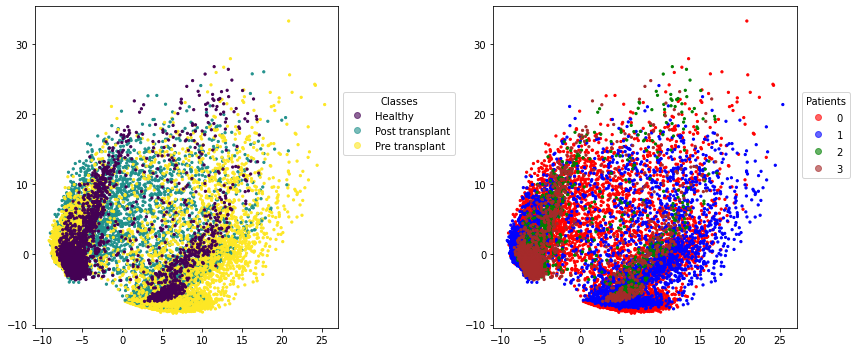

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Label converter converts the (string) conditions to numberic as required by matplotlib
label_encoder = LabelEncoder().fit(metadata['condition'])

scatter1 = ax1.scatter(data_pca[:, 0], data_pca[:, 1], s=5, c=label_encoder.transform(metadata['condition']))

handles, labels = scatter1.legend_elements(alpha=0.6)
ax1.legend(
    handles,
    label_encoder.inverse_transform([0, 1, 2]), # Get back the initial (string) class names from the label encoder
    loc="upper left",
    title="Classes",
    bbox_to_anchor=(1, 0.75)
)

scatter2 = ax2.scatter(data_pca[:, 0], data_pca[:, 1], s=5, c=metadata['patient_id'], cmap=ListedColormap(['red', 'blue', 'green', 'brown']))

handles, labels = scatter2.legend_elements(alpha=0.6)
ax2.legend(
    handles,
    labels, 
    loc="upper left",
    title="Patients",
    bbox_to_anchor=(1, 0.75)
)

plt.tight_layout()

It's hard to discern much from our plots (there's a lot of mixing between classes!) but this mixing is actually what we would expect based on papers that have used this dataset before. This mixing is actually the motivation for "contrastive disentanglement" methods, which can tease out the variations that might separate different groups here.

### Finally, we save our preprocessed data and metadata to disk

In [10]:
stacked_df.to_csv("./preprocessed_data.csv")
metadata.to_csv("./metadata.csv")